In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np

# Learning Rate Scheduling

Part of the traditional machine learning recipe is to decay our learning rate over time. This ensures that we get fast learning early on, but can get that last push of performance near the edge. Let's see how much this matters, and if we can get away without it.

## Classical Optimization: Decay your learning rate

In classical optimization theory, learning rate must decay for us to get certain convergence guarantees. The intution is that if we stay at a constant learning rate forever, we'll end up bouncing around the optimum and won't converge to the exact point. 

## Experiment: Learning rate decay with MNIST

Let's use our classic MNIST example from the chapter on optimization. We'll use Adam as our optimizer, and try out a range of learning rate decay strategies.

In [18]:
from keras.datasets import mnist
(train_images, train_labels), (valid_images, valid_labels) = mnist.load_data()

class Classifier(nn.Module):
    features: int = 512
    num_classes: int = 10

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(self.num_classes)(x)
        return x

def sample_batch(key, batchsize, images, labels):
    idx = jax.random.randint(key, (batchsize,), 0, images.shape[0])
    return jnp.reshape(images[idx], (batchsize, -1)), labels[idx]

def learn_mnist(update_fn, init_opt_state, max_steps=1000):
    train_losses, valid_losses = [], []
    classifier = Classifier()
    key = jax.random.PRNGKey(0)
    key, param_key = jax.random.split(key)
    images, labels = sample_batch(param_key, 256, train_images, train_labels)
    v_images, v_labels = sample_batch(jax.random.PRNGKey(1), 1024, valid_images, valid_labels)
    params = classifier.init(param_key, images)['params']
    opt_state = init_opt_state(params)
    loss_fn = jax.jit(lambda p, x, y: jnp.mean(nn.log_softmax(classifier.apply({'params': p}, x)) * -jnp.eye(10)[y]))
    grad_fn = jax.jit(jax.value_and_grad(loss_fn))
    for i in range(max_steps):
        key, data_key = jax.random.split(key)
        images, labels = sample_batch(data_key, 256, train_images, train_labels)
        loss, grads = grad_fn(params, images, labels)
        params, opt_state = update_fn(params, grads, opt_state, i/max_steps)
        train_losses.append(loss)
        valid_losses.append(loss_fn(params, v_images, v_labels))
    
    return train_losses, valid_losses

def plot_losses(losses, labels):
    fig, axs = plt.subplots(1, figsize=(4, 2))
    for loss, label in zip(losses, labels):
        axs.plot(loss, label=label)
    axs.legend()
    axs.set_ylim([0, 1])
    plt.show()

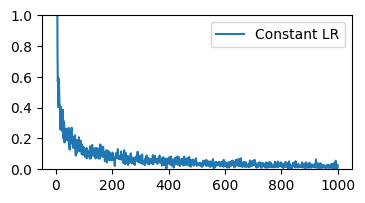

In [17]:
@jax.jit
def sgd_constant(params, grads, opt_state, step_fraction):
    lr = 0.01
    return jax.tree_map(lambda p, g: p - lr * g, params, grads), None
init_opt_state = lambda p: None
train_losses, valid_losses = learn_mnist(sgd_constant, init_opt_state)
plot_losses([train_losses], ['Constant LR'])

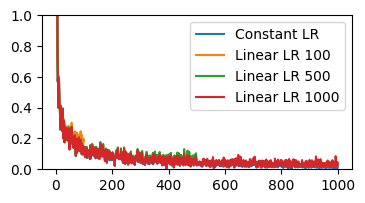

In [21]:
@jax.jit
def sgd_linear(params, grads, opt_state, step_fraction):
    lr = 0.01 * (1 - step_fraction)
    return jax.tree_map(lambda p, g: p - lr * g, params, grads), None
init_opt_state = lambda p: None

losses = [train_losses]
labels = ['Constant LR']
for max_steps in [100, 500, 1000]:
    l, _ = learn_mnist(sgd_linear, init_opt_state, max_steps=max_steps)
    losses.append(l)
    labels.append(f'Linear LR {max_steps}')
plot_losses(losses, labels)

## Adaptive Learning Rate (Adagrad)

In the quadratic example, we saw how we can get faster convergence by using different learning rates per coordinate. **Adagrad** gives us a method of doing the same for deep neural networks. Adagrad can be seen as a preconditioned gradient descent method, where $P$ is a diagonal matrix. In other words, we will use an independent learning rate for *each parameter* in our network.

Recall the core issue -- some parameters affect the loss more than others. We want to normalize for this. Adagrad achieves this by keeping track of **per-parameter gradient variance**. When taking each gradient step, we will divide the gradient elementwise by these historical variances.

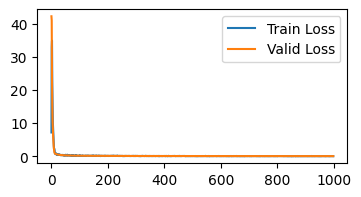

Loss is below 0.15 at iteration 171


In [89]:
@jax.jit
def adagrad(params, grads, variances):
    scaled_grads = jax.tree_map(lambda g, v: g / (jnp.sqrt(v + 1e-3)), grads, variances)
    new_params = jax.tree_map(lambda p, g: p - 0.001 * g, params, scaled_grads)
    new_variances = jax.tree_map(lambda v, g: v + g ** 2, variances, grads)
    return new_params, new_variances
init_variances = lambda p: jax.tree_map(lambda x: jnp.zeros_like(x), p)
learn_mnist(adagrad, init_variances)

## Momentum

Variance in our gradient direction can come from two main sources. First, the nature of stochastic gradient descent means we sample a new batch every update, which can be seen as adding noise to our gradient. Second, updates that are too large can result in oscillations in gradient direction.

To reduce these variances, we can condition our update not just on the current batch, but also an average of *past* gradients, which we call **momentum**. This technique is also known as the *heavy ball method*, as it resembles our parameters having mass that maintains past directions. 

A simple way to implement momentum is to keep track of an exponential moving average of the gradient by introducing a new momentum state $m$:

$$
m' \leftarrow \beta m + \nabla L(\theta)
\theta' \leftarrow x' - \alpha m'
$$

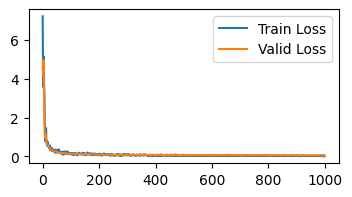

Loss is below 0.15 at iteration 83


In [90]:
@jax.jit
def momentum_update(params, grads, momentum):
    new_momentum = jax.tree_map(lambda m, g: 0.9 * m + g, momentum, grads)
    new_params = jax.tree_map(lambda p, g: p - 0.001 * g, params, new_momentum)
    return new_params, new_momentum
init_momentum = lambda m: jax.tree_map(lambda x: jnp.zeros_like(x), m)
learn_mnist(momentum_update, init_momentum)

## Adam

The most frequently used optimizer today is **Adam**, which combines insights from adaptive learning rates and momentum. Adam uses an exponential moving average to keep track of both past gradients (i.e. momentum) and past gradient *variances* (as we did in Adagrad):

$$
\begin{align}
m' & \leftarrow \beta_1 m + (1-\beta_1) \nabla L(\theta) \\
s' & \leftarrow \beta_2 s + (1-\beta_2) (\nabla L(\theta))^2
\end{align}
$$

Notice that the equations are slightly different then in Adagrad or momentum. The point of these changes is to keep the scales of the momentum and variance estimates consistent. Adagrad has a problem where keeping track of the sum of historical variances will rapidly go to infinity. Our simple momentum implementation is also weird, as the momentum magnitude will converge to approximately $1/(1-\beta)$. Instead, we would like to keep magnitudes normalized.

Because we initialize $m$ and $s$ to zero, at the beginning of training our estimates are closer to zero than we would like. Thus, in Adam we account for this and scale $m$ and $s$ by a scalar depending on training step:

$$
\hat{m_t} = m_t / (1-\beta^t_1) \quad \text{and} \quad \hat{s_t} = s_t / (1-\beta^t_2)
\theta \leftarrow \theta - \alpha m / (\sqrt{s} + \eps)
$$

where $\beta^t$ represents $\beta$ to the power $t$.

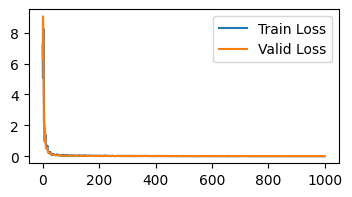

Loss is below 0.15 at iteration 29


In [92]:
@jax.jit
def adam_update(params, grads, opt_state):
    momentum, variance = opt_state
    new_momentum = jax.tree_map(lambda m, g: 0.9 * m + g, momentum, grads)
    new_variance = jax.tree_map(lambda v, g: 0.999 * v + g ** 2, variance, grads)
    update = jax.tree_map(lambda m, v: m / (jnp.sqrt(v) + 1e-6), new_momentum, new_variance)
    new_params = jax.tree_map(lambda p, u: p - 0.001 * u, params, update)
    return new_params, (new_momentum, new_variance)
init_opt_state = lambda m: (jax.tree_map(lambda x: jnp.zeros_like(x), m), jax.tree_map(lambda x: jnp.zeros_like(x), m))
learn_mnist(adam_update, init_opt_state)

## Summary of optimization results

Iteration where loss goes below 0.15:
- SGD: 825
- Adagrad: 171
- Momentum: 83
- **Adam: 29**

So, there's a reason why Adam is the most popular algorithm today. It's reliable, converges fast, and does not require much hyperparamter tuning. The main downside to Adam is it requires storing 3x the parameter count (parameters, momentum, variance) which can consume more memory.

For more on optimization, check out the page on [second order optimization methods] (todo).